In [1]:
from PIL import Image
import cv2
import requests
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import torch
from torch import nn
from torchvision.ops import nms
from torchvision import transforms

from torchvision.models import resnet50
import torchvision.transforms as T
torch.set_grad_enabled(False);

In [14]:
class DETRmodel(nn.Module):
    """
    Demo DETR implementation.

    Demo implementation of DETR in minimal number of lines, with the
    following differences wrt DETR in the paper:
    * learned positional encoding (instead of sine)
    * positional encoding is passed at input (instead of attention)
    * fc bbox predictor (instead of MLP)
    The model achieves ~40 AP on COCO val5k and runs at ~28 FPS on Tesla V100.
    Only batch size 1 supported.
    """
    def __init__(self, num_classes, hidden_dim=256, nheads=8,
                 num_encoder_layers=6, num_decoder_layers=6):
        super().__init__()

        # create ResNet-50 backbone
        self.backbone = resnet50()
        del self.backbone.fc

        # create conversion layer
        self.conv = nn.Conv2d(2048, hidden_dim, 1)

        # create a default PyTorch transformer
        self.transformer = nn.Transformer(
            hidden_dim, nheads, num_encoder_layers, num_decoder_layers)

        # prediction heads, one extra class for predicting non-empty slots
        # note that in baseline DETR linear_bbox layer is 3-layer MLP
        self.linear_class = nn.Linear(hidden_dim, num_classes + 1)
        self.linear_bbox = nn.Linear(hidden_dim, 4)

        # output positional encodings (object queries)
        self.query_pos = nn.Parameter(torch.rand(100, hidden_dim))

        # spatial positional encodings
        # note that in baseline DETR we use sine positional encodings
        self.row_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))
        self.col_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))

    def forward(self, inputs):
        # propagate inputs through ResNet-50 up to avg-pool layer
        x = self.backbone.conv1(inputs)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)

        # convert from 2048 to 256 feature planes for the transformer
        h = self.conv(x)

        # construct positional encodings
        H, W = h.shape[-2:]
        pos = torch.cat([
            self.col_embed[:W].unsqueeze(0).repeat(H, 1, 1),
            self.row_embed[:H].unsqueeze(1).repeat(1, W, 1),
        ], dim=-1).flatten(0, 1).unsqueeze(1)

        # propagate through the transformer
        h = self.transformer(pos + 0.1 * h.flatten(2).permute(2, 0, 1),
                             self.query_pos.unsqueeze(1)).transpose(0, 1)
        
        # finally project transformer outputs to class labels and bounding boxes
        return {'pred_logits': self.linear_class(h), 
                'pred_boxes': self.linear_bbox(h).sigmoid()}

In [16]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda', index=0)

In [17]:
def load_detr(weights_url,num_classes=91,try_gpu=True,gpu_id="cuda:0"):
    #"file:/opt/quantum/detr-1/weights/detr.pth"
    ##'https://dl.fbaipublicfiles.com/detr/detr_demo-da2a99e9.pth'
    DEVICE=torch.device("cpu")
    if try_gpu:
        DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f'DEVICE: {DEVICE}, num_classes: {num_classes}')    

    model = DETRmodel(num_classes=num_classes)
    state_dict=torch.hub.load_state_dict_from_url(
        url=weights_url,
        map_location='cpu', 
        check_hash=True
    )
    model.load_state_dict(state_dict)
    model.to(DEVICE)
    model.eval()
    return model

In [18]:
#detr = DETRdemo(num_classes=91)
##"file:/opt/quantum/detr-1/weights/detr-r50-e632da11.pth"
#state_dict = torch.hub.load_state_dict_from_url(
#    url="file:/opt/quantum/detr-1/weights/detr.pth", #'https://dl.fbaipublicfiles.com/detr/detr_demo-da2a99e9.pth',
#    map_location='cpu', check_hash=True)
#torch.save(state_dict,"../../detr.pth")
#print(state_dict.keys())
#detr.load_state_dict(state_dict)
##detr.to(DEVICE)
#detr.eval();

#detr=load_detr('file:/opt/quantum/detr-1/weights/detr.pth',try_gpu=True)
#detr=load_detr('file:/opt/quantum/vision_transformers/runs/training/detr_resnet50/best_model.pth',num_classes=6,try_gpu=True)
detr=load_detr('file:/opt/quantum/vision_transformers/runs/training/detr_resnet50/best_model.pth',num_classes=6,try_gpu=True)


DEVICE: cuda:0, num_classes: 6


/home/fgerard/anaconda3/envs/vision_transformers/lib/python3.12/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


RuntimeError: Error(s) in loading state_dict for DETRmodel:
	Missing key(s) in state_dict: "query_pos", "row_embed", "col_embed", "backbone.conv1.weight", "backbone.bn1.weight", "backbone.bn1.bias", "backbone.bn1.running_mean", "backbone.bn1.running_var", "backbone.layer1.0.conv1.weight", "backbone.layer1.0.bn1.weight", "backbone.layer1.0.bn1.bias", "backbone.layer1.0.bn1.running_mean", "backbone.layer1.0.bn1.running_var", "backbone.layer1.0.conv2.weight", "backbone.layer1.0.bn2.weight", "backbone.layer1.0.bn2.bias", "backbone.layer1.0.bn2.running_mean", "backbone.layer1.0.bn2.running_var", "backbone.layer1.0.conv3.weight", "backbone.layer1.0.bn3.weight", "backbone.layer1.0.bn3.bias", "backbone.layer1.0.bn3.running_mean", "backbone.layer1.0.bn3.running_var", "backbone.layer1.0.downsample.0.weight", "backbone.layer1.0.downsample.1.weight", "backbone.layer1.0.downsample.1.bias", "backbone.layer1.0.downsample.1.running_mean", "backbone.layer1.0.downsample.1.running_var", "backbone.layer1.1.conv1.weight", "backbone.layer1.1.bn1.weight", "backbone.layer1.1.bn1.bias", "backbone.layer1.1.bn1.running_mean", "backbone.layer1.1.bn1.running_var", "backbone.layer1.1.conv2.weight", "backbone.layer1.1.bn2.weight", "backbone.layer1.1.bn2.bias", "backbone.layer1.1.bn2.running_mean", "backbone.layer1.1.bn2.running_var", "backbone.layer1.1.conv3.weight", "backbone.layer1.1.bn3.weight", "backbone.layer1.1.bn3.bias", "backbone.layer1.1.bn3.running_mean", "backbone.layer1.1.bn3.running_var", "backbone.layer1.2.conv1.weight", "backbone.layer1.2.bn1.weight", "backbone.layer1.2.bn1.bias", "backbone.layer1.2.bn1.running_mean", "backbone.layer1.2.bn1.running_var", "backbone.layer1.2.conv2.weight", "backbone.layer1.2.bn2.weight", "backbone.layer1.2.bn2.bias", "backbone.layer1.2.bn2.running_mean", "backbone.layer1.2.bn2.running_var", "backbone.layer1.2.conv3.weight", "backbone.layer1.2.bn3.weight", "backbone.layer1.2.bn3.bias", "backbone.layer1.2.bn3.running_mean", "backbone.layer1.2.bn3.running_var", "backbone.layer2.0.conv1.weight", "backbone.layer2.0.bn1.weight", "backbone.layer2.0.bn1.bias", "backbone.layer2.0.bn1.running_mean", "backbone.layer2.0.bn1.running_var", "backbone.layer2.0.conv2.weight", "backbone.layer2.0.bn2.weight", "backbone.layer2.0.bn2.bias", "backbone.layer2.0.bn2.running_mean", "backbone.layer2.0.bn2.running_var", "backbone.layer2.0.conv3.weight", "backbone.layer2.0.bn3.weight", "backbone.layer2.0.bn3.bias", "backbone.layer2.0.bn3.running_mean", "backbone.layer2.0.bn3.running_var", "backbone.layer2.0.downsample.0.weight", "backbone.layer2.0.downsample.1.weight", "backbone.layer2.0.downsample.1.bias", "backbone.layer2.0.downsample.1.running_mean", "backbone.layer2.0.downsample.1.running_var", "backbone.layer2.1.conv1.weight", "backbone.layer2.1.bn1.weight", "backbone.layer2.1.bn1.bias", "backbone.layer2.1.bn1.running_mean", "backbone.layer2.1.bn1.running_var", "backbone.layer2.1.conv2.weight", "backbone.layer2.1.bn2.weight", "backbone.layer2.1.bn2.bias", "backbone.layer2.1.bn2.running_mean", "backbone.layer2.1.bn2.running_var", "backbone.layer2.1.conv3.weight", "backbone.layer2.1.bn3.weight", "backbone.layer2.1.bn3.bias", "backbone.layer2.1.bn3.running_mean", "backbone.layer2.1.bn3.running_var", "backbone.layer2.2.conv1.weight", "backbone.layer2.2.bn1.weight", "backbone.layer2.2.bn1.bias", "backbone.layer2.2.bn1.running_mean", "backbone.layer2.2.bn1.running_var", "backbone.layer2.2.conv2.weight", "backbone.layer2.2.bn2.weight", "backbone.layer2.2.bn2.bias", "backbone.layer2.2.bn2.running_mean", "backbone.layer2.2.bn2.running_var", "backbone.layer2.2.conv3.weight", "backbone.layer2.2.bn3.weight", "backbone.layer2.2.bn3.bias", "backbone.layer2.2.bn3.running_mean", "backbone.layer2.2.bn3.running_var", "backbone.layer2.3.conv1.weight", "backbone.layer2.3.bn1.weight", "backbone.layer2.3.bn1.bias", "backbone.layer2.3.bn1.running_mean", "backbone.layer2.3.bn1.running_var", "backbone.layer2.3.conv2.weight", "backbone.layer2.3.bn2.weight", "backbone.layer2.3.bn2.bias", "backbone.layer2.3.bn2.running_mean", "backbone.layer2.3.bn2.running_var", "backbone.layer2.3.conv3.weight", "backbone.layer2.3.bn3.weight", "backbone.layer2.3.bn3.bias", "backbone.layer2.3.bn3.running_mean", "backbone.layer2.3.bn3.running_var", "backbone.layer3.0.conv1.weight", "backbone.layer3.0.bn1.weight", "backbone.layer3.0.bn1.bias", "backbone.layer3.0.bn1.running_mean", "backbone.layer3.0.bn1.running_var", "backbone.layer3.0.conv2.weight", "backbone.layer3.0.bn2.weight", "backbone.layer3.0.bn2.bias", "backbone.layer3.0.bn2.running_mean", "backbone.layer3.0.bn2.running_var", "backbone.layer3.0.conv3.weight", "backbone.layer3.0.bn3.weight", "backbone.layer3.0.bn3.bias", "backbone.layer3.0.bn3.running_mean", "backbone.layer3.0.bn3.running_var", "backbone.layer3.0.downsample.0.weight", "backbone.layer3.0.downsample.1.weight", "backbone.layer3.0.downsample.1.bias", "backbone.layer3.0.downsample.1.running_mean", "backbone.layer3.0.downsample.1.running_var", "backbone.layer3.1.conv1.weight", "backbone.layer3.1.bn1.weight", "backbone.layer3.1.bn1.bias", "backbone.layer3.1.bn1.running_mean", "backbone.layer3.1.bn1.running_var", "backbone.layer3.1.conv2.weight", "backbone.layer3.1.bn2.weight", "backbone.layer3.1.bn2.bias", "backbone.layer3.1.bn2.running_mean", "backbone.layer3.1.bn2.running_var", "backbone.layer3.1.conv3.weight", "backbone.layer3.1.bn3.weight", "backbone.layer3.1.bn3.bias", "backbone.layer3.1.bn3.running_mean", "backbone.layer3.1.bn3.running_var", "backbone.layer3.2.conv1.weight", "backbone.layer3.2.bn1.weight", "backbone.layer3.2.bn1.bias", "backbone.layer3.2.bn1.running_mean", "backbone.layer3.2.bn1.running_var", "backbone.layer3.2.conv2.weight", "backbone.layer3.2.bn2.weight", "backbone.layer3.2.bn2.bias", "backbone.layer3.2.bn2.running_mean", "backbone.layer3.2.bn2.running_var", "backbone.layer3.2.conv3.weight", "backbone.layer3.2.bn3.weight", "backbone.layer3.2.bn3.bias", "backbone.layer3.2.bn3.running_mean", "backbone.layer3.2.bn3.running_var", "backbone.layer3.3.conv1.weight", "backbone.layer3.3.bn1.weight", "backbone.layer3.3.bn1.bias", "backbone.layer3.3.bn1.running_mean", "backbone.layer3.3.bn1.running_var", "backbone.layer3.3.conv2.weight", "backbone.layer3.3.bn2.weight", "backbone.layer3.3.bn2.bias", "backbone.layer3.3.bn2.running_mean", "backbone.layer3.3.bn2.running_var", "backbone.layer3.3.conv3.weight", "backbone.layer3.3.bn3.weight", "backbone.layer3.3.bn3.bias", "backbone.layer3.3.bn3.running_mean", "backbone.layer3.3.bn3.running_var", "backbone.layer3.4.conv1.weight", "backbone.layer3.4.bn1.weight", "backbone.layer3.4.bn1.bias", "backbone.layer3.4.bn1.running_mean", "backbone.layer3.4.bn1.running_var", "backbone.layer3.4.conv2.weight", "backbone.layer3.4.bn2.weight", "backbone.layer3.4.bn2.bias", "backbone.layer3.4.bn2.running_mean", "backbone.layer3.4.bn2.running_var", "backbone.layer3.4.conv3.weight", "backbone.layer3.4.bn3.weight", "backbone.layer3.4.bn3.bias", "backbone.layer3.4.bn3.running_mean", "backbone.layer3.4.bn3.running_var", "backbone.layer3.5.conv1.weight", "backbone.layer3.5.bn1.weight", "backbone.layer3.5.bn1.bias", "backbone.layer3.5.bn1.running_mean", "backbone.layer3.5.bn1.running_var", "backbone.layer3.5.conv2.weight", "backbone.layer3.5.bn2.weight", "backbone.layer3.5.bn2.bias", "backbone.layer3.5.bn2.running_mean", "backbone.layer3.5.bn2.running_var", "backbone.layer3.5.conv3.weight", "backbone.layer3.5.bn3.weight", "backbone.layer3.5.bn3.bias", "backbone.layer3.5.bn3.running_mean", "backbone.layer3.5.bn3.running_var", "backbone.layer4.0.conv1.weight", "backbone.layer4.0.bn1.weight", "backbone.layer4.0.bn1.bias", "backbone.layer4.0.bn1.running_mean", "backbone.layer4.0.bn1.running_var", "backbone.layer4.0.conv2.weight", "backbone.layer4.0.bn2.weight", "backbone.layer4.0.bn2.bias", "backbone.layer4.0.bn2.running_mean", "backbone.layer4.0.bn2.running_var", "backbone.layer4.0.conv3.weight", "backbone.layer4.0.bn3.weight", "backbone.layer4.0.bn3.bias", "backbone.layer4.0.bn3.running_mean", "backbone.layer4.0.bn3.running_var", "backbone.layer4.0.downsample.0.weight", "backbone.layer4.0.downsample.1.weight", "backbone.layer4.0.downsample.1.bias", "backbone.layer4.0.downsample.1.running_mean", "backbone.layer4.0.downsample.1.running_var", "backbone.layer4.1.conv1.weight", "backbone.layer4.1.bn1.weight", "backbone.layer4.1.bn1.bias", "backbone.layer4.1.bn1.running_mean", "backbone.layer4.1.bn1.running_var", "backbone.layer4.1.conv2.weight", "backbone.layer4.1.bn2.weight", "backbone.layer4.1.bn2.bias", "backbone.layer4.1.bn2.running_mean", "backbone.layer4.1.bn2.running_var", "backbone.layer4.1.conv3.weight", "backbone.layer4.1.bn3.weight", "backbone.layer4.1.bn3.bias", "backbone.layer4.1.bn3.running_mean", "backbone.layer4.1.bn3.running_var", "backbone.layer4.2.conv1.weight", "backbone.layer4.2.bn1.weight", "backbone.layer4.2.bn1.bias", "backbone.layer4.2.bn1.running_mean", "backbone.layer4.2.bn1.running_var", "backbone.layer4.2.conv2.weight", "backbone.layer4.2.bn2.weight", "backbone.layer4.2.bn2.bias", "backbone.layer4.2.bn2.running_mean", "backbone.layer4.2.bn2.running_var", "backbone.layer4.2.conv3.weight", "backbone.layer4.2.bn3.weight", "backbone.layer4.2.bn3.bias", "backbone.layer4.2.bn3.running_mean", "backbone.layer4.2.bn3.running_var", "conv.weight", "conv.bias", "transformer.encoder.layers.0.self_attn.in_proj_weight", "transformer.encoder.layers.0.self_attn.in_proj_bias", "transformer.encoder.layers.0.self_attn.out_proj.weight", "transformer.encoder.layers.0.self_attn.out_proj.bias", "transformer.encoder.layers.0.linear1.weight", "transformer.encoder.layers.0.linear1.bias", "transformer.encoder.layers.0.linear2.weight", "transformer.encoder.layers.0.linear2.bias", "transformer.encoder.layers.0.norm1.weight", "transformer.encoder.layers.0.norm1.bias", "transformer.encoder.layers.0.norm2.weight", "transformer.encoder.layers.0.norm2.bias", "transformer.encoder.layers.1.self_attn.in_proj_weight", "transformer.encoder.layers.1.self_attn.in_proj_bias", "transformer.encoder.layers.1.self_attn.out_proj.weight", "transformer.encoder.layers.1.self_attn.out_proj.bias", "transformer.encoder.layers.1.linear1.weight", "transformer.encoder.layers.1.linear1.bias", "transformer.encoder.layers.1.linear2.weight", "transformer.encoder.layers.1.linear2.bias", "transformer.encoder.layers.1.norm1.weight", "transformer.encoder.layers.1.norm1.bias", "transformer.encoder.layers.1.norm2.weight", "transformer.encoder.layers.1.norm2.bias", "transformer.encoder.layers.2.self_attn.in_proj_weight", "transformer.encoder.layers.2.self_attn.in_proj_bias", "transformer.encoder.layers.2.self_attn.out_proj.weight", "transformer.encoder.layers.2.self_attn.out_proj.bias", "transformer.encoder.layers.2.linear1.weight", "transformer.encoder.layers.2.linear1.bias", "transformer.encoder.layers.2.linear2.weight", "transformer.encoder.layers.2.linear2.bias", "transformer.encoder.layers.2.norm1.weight", "transformer.encoder.layers.2.norm1.bias", "transformer.encoder.layers.2.norm2.weight", "transformer.encoder.layers.2.norm2.bias", "transformer.encoder.layers.3.self_attn.in_proj_weight", "transformer.encoder.layers.3.self_attn.in_proj_bias", "transformer.encoder.layers.3.self_attn.out_proj.weight", "transformer.encoder.layers.3.self_attn.out_proj.bias", "transformer.encoder.layers.3.linear1.weight", "transformer.encoder.layers.3.linear1.bias", "transformer.encoder.layers.3.linear2.weight", "transformer.encoder.layers.3.linear2.bias", "transformer.encoder.layers.3.norm1.weight", "transformer.encoder.layers.3.norm1.bias", "transformer.encoder.layers.3.norm2.weight", "transformer.encoder.layers.3.norm2.bias", "transformer.encoder.layers.4.self_attn.in_proj_weight", "transformer.encoder.layers.4.self_attn.in_proj_bias", "transformer.encoder.layers.4.self_attn.out_proj.weight", "transformer.encoder.layers.4.self_attn.out_proj.bias", "transformer.encoder.layers.4.linear1.weight", "transformer.encoder.layers.4.linear1.bias", "transformer.encoder.layers.4.linear2.weight", "transformer.encoder.layers.4.linear2.bias", "transformer.encoder.layers.4.norm1.weight", "transformer.encoder.layers.4.norm1.bias", "transformer.encoder.layers.4.norm2.weight", "transformer.encoder.layers.4.norm2.bias", "transformer.encoder.layers.5.self_attn.in_proj_weight", "transformer.encoder.layers.5.self_attn.in_proj_bias", "transformer.encoder.layers.5.self_attn.out_proj.weight", "transformer.encoder.layers.5.self_attn.out_proj.bias", "transformer.encoder.layers.5.linear1.weight", "transformer.encoder.layers.5.linear1.bias", "transformer.encoder.layers.5.linear2.weight", "transformer.encoder.layers.5.linear2.bias", "transformer.encoder.layers.5.norm1.weight", "transformer.encoder.layers.5.norm1.bias", "transformer.encoder.layers.5.norm2.weight", "transformer.encoder.layers.5.norm2.bias", "transformer.encoder.norm.weight", "transformer.encoder.norm.bias", "transformer.decoder.layers.0.self_attn.in_proj_weight", "transformer.decoder.layers.0.self_attn.in_proj_bias", "transformer.decoder.layers.0.self_attn.out_proj.weight", "transformer.decoder.layers.0.self_attn.out_proj.bias", "transformer.decoder.layers.0.multihead_attn.in_proj_weight", "transformer.decoder.layers.0.multihead_attn.in_proj_bias", "transformer.decoder.layers.0.multihead_attn.out_proj.weight", "transformer.decoder.layers.0.multihead_attn.out_proj.bias", "transformer.decoder.layers.0.linear1.weight", "transformer.decoder.layers.0.linear1.bias", "transformer.decoder.layers.0.linear2.weight", "transformer.decoder.layers.0.linear2.bias", "transformer.decoder.layers.0.norm1.weight", "transformer.decoder.layers.0.norm1.bias", "transformer.decoder.layers.0.norm2.weight", "transformer.decoder.layers.0.norm2.bias", "transformer.decoder.layers.0.norm3.weight", "transformer.decoder.layers.0.norm3.bias", "transformer.decoder.layers.1.self_attn.in_proj_weight", "transformer.decoder.layers.1.self_attn.in_proj_bias", "transformer.decoder.layers.1.self_attn.out_proj.weight", "transformer.decoder.layers.1.self_attn.out_proj.bias", "transformer.decoder.layers.1.multihead_attn.in_proj_weight", "transformer.decoder.layers.1.multihead_attn.in_proj_bias", "transformer.decoder.layers.1.multihead_attn.out_proj.weight", "transformer.decoder.layers.1.multihead_attn.out_proj.bias", "transformer.decoder.layers.1.linear1.weight", "transformer.decoder.layers.1.linear1.bias", "transformer.decoder.layers.1.linear2.weight", "transformer.decoder.layers.1.linear2.bias", "transformer.decoder.layers.1.norm1.weight", "transformer.decoder.layers.1.norm1.bias", "transformer.decoder.layers.1.norm2.weight", "transformer.decoder.layers.1.norm2.bias", "transformer.decoder.layers.1.norm3.weight", "transformer.decoder.layers.1.norm3.bias", "transformer.decoder.layers.2.self_attn.in_proj_weight", "transformer.decoder.layers.2.self_attn.in_proj_bias", "transformer.decoder.layers.2.self_attn.out_proj.weight", "transformer.decoder.layers.2.self_attn.out_proj.bias", "transformer.decoder.layers.2.multihead_attn.in_proj_weight", "transformer.decoder.layers.2.multihead_attn.in_proj_bias", "transformer.decoder.layers.2.multihead_attn.out_proj.weight", "transformer.decoder.layers.2.multihead_attn.out_proj.bias", "transformer.decoder.layers.2.linear1.weight", "transformer.decoder.layers.2.linear1.bias", "transformer.decoder.layers.2.linear2.weight", "transformer.decoder.layers.2.linear2.bias", "transformer.decoder.layers.2.norm1.weight", "transformer.decoder.layers.2.norm1.bias", "transformer.decoder.layers.2.norm2.weight", "transformer.decoder.layers.2.norm2.bias", "transformer.decoder.layers.2.norm3.weight", "transformer.decoder.layers.2.norm3.bias", "transformer.decoder.layers.3.self_attn.in_proj_weight", "transformer.decoder.layers.3.self_attn.in_proj_bias", "transformer.decoder.layers.3.self_attn.out_proj.weight", "transformer.decoder.layers.3.self_attn.out_proj.bias", "transformer.decoder.layers.3.multihead_attn.in_proj_weight", "transformer.decoder.layers.3.multihead_attn.in_proj_bias", "transformer.decoder.layers.3.multihead_attn.out_proj.weight", "transformer.decoder.layers.3.multihead_attn.out_proj.bias", "transformer.decoder.layers.3.linear1.weight", "transformer.decoder.layers.3.linear1.bias", "transformer.decoder.layers.3.linear2.weight", "transformer.decoder.layers.3.linear2.bias", "transformer.decoder.layers.3.norm1.weight", "transformer.decoder.layers.3.norm1.bias", "transformer.decoder.layers.3.norm2.weight", "transformer.decoder.layers.3.norm2.bias", "transformer.decoder.layers.3.norm3.weight", "transformer.decoder.layers.3.norm3.bias", "transformer.decoder.layers.4.self_attn.in_proj_weight", "transformer.decoder.layers.4.self_attn.in_proj_bias", "transformer.decoder.layers.4.self_attn.out_proj.weight", "transformer.decoder.layers.4.self_attn.out_proj.bias", "transformer.decoder.layers.4.multihead_attn.in_proj_weight", "transformer.decoder.layers.4.multihead_attn.in_proj_bias", "transformer.decoder.layers.4.multihead_attn.out_proj.weight", "transformer.decoder.layers.4.multihead_attn.out_proj.bias", "transformer.decoder.layers.4.linear1.weight", "transformer.decoder.layers.4.linear1.bias", "transformer.decoder.layers.4.linear2.weight", "transformer.decoder.layers.4.linear2.bias", "transformer.decoder.layers.4.norm1.weight", "transformer.decoder.layers.4.norm1.bias", "transformer.decoder.layers.4.norm2.weight", "transformer.decoder.layers.4.norm2.bias", "transformer.decoder.layers.4.norm3.weight", "transformer.decoder.layers.4.norm3.bias", "transformer.decoder.layers.5.self_attn.in_proj_weight", "transformer.decoder.layers.5.self_attn.in_proj_bias", "transformer.decoder.layers.5.self_attn.out_proj.weight", "transformer.decoder.layers.5.self_attn.out_proj.bias", "transformer.decoder.layers.5.multihead_attn.in_proj_weight", "transformer.decoder.layers.5.multihead_attn.in_proj_bias", "transformer.decoder.layers.5.multihead_attn.out_proj.weight", "transformer.decoder.layers.5.multihead_attn.out_proj.bias", "transformer.decoder.layers.5.linear1.weight", "transformer.decoder.layers.5.linear1.bias", "transformer.decoder.layers.5.linear2.weight", "transformer.decoder.layers.5.linear2.bias", "transformer.decoder.layers.5.norm1.weight", "transformer.decoder.layers.5.norm1.bias", "transformer.decoder.layers.5.norm2.weight", "transformer.decoder.layers.5.norm2.bias", "transformer.decoder.layers.5.norm3.weight", "transformer.decoder.layers.5.norm3.bias", "transformer.decoder.norm.weight", "transformer.decoder.norm.bias", "linear_class.weight", "linear_class.bias", "linear_bbox.weight", "linear_bbox.bias". 
	Unexpected key(s) in state_dict: "epoch", "model_state_dict", "config", "model_name". 

In [37]:
# COCO classes
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]
CLASSES = ["tractor","caja","cortina","llanta","producto"]

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

In [30]:
# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox_xyxy, size):
    img_w, img_h = size
    b = out_bbox_xyxy * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32).to(DEVICE)
    return b

def create_objects(prob,boxes):
    result=[]
    for p, (xmin, ymin, xmax, ymax) in zip(prob, boxes.tolist()):
        cl = p.argmax()
        prob = p[cl].item()*100
        result.append([int(cl),int(prob),int(xmin),int(ymin),int(xmax),int(ymax)])
    return result


In [31]:
def detect(im, model, transform, min_score=0.7, iou_threshold=0.5):
    # mean-std normalize the input image (batch-size: 1)
    img = transform(im).unsqueeze(0).to(DEVICE)

    # demo model only support by default images with aspect ratio between 0.5 and 2
    # if you want to use images with an aspect ratio outside this range
    # rescale your image so that the maximum size is at most 1333 for best results
    assert img.shape[-2] <= 1600 and img.shape[-1] <= 1600, 'demo model only supports images up to 1600 pixels on each side'

    # propagate through the model
    outputs = model(img)

    # keep only predictions with 0.7+ confidence
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > min_score

    ## hacer NMS
    max_score_values=probas.max(-1).values
    boxes_xyxy=box_cxcywh_to_xyxy(outputs['pred_boxes'][0])
    
    #print("probas: {} {}".format(max_score_values.shape,max_score_values))
    #print("boxes_xyxy: {} {}".format(boxes_xyxy.shape,boxes_xyxy))
    
    good_index=nms(boxes=boxes_xyxy,scores=max_score_values, iou_threshold=iou_threshold)
    
    #print("good_index: {} {}".format(good_index.shape,good_index))

    d_keep=torch.zeros(100, dtype=torch.bool).to(DEVICE)
    d_keep[good_index]=True
    #print("keep: {} {} {}".format(keep.shape,keep,torch.sum(keep).item()))
    #print("d_keep: {} {} {}".format(d_keep.shape,d_keep,torch.sum(d_keep).item()))
    keep = torch.logical_and(keep, d_keep)
    #print("2keep: {} {} {}".format(keep.shape,keep,torch.sum(keep).item()))

    bboxes_scaled = rescale_bboxes(boxes_xyxy[keep], im.size)
    return probas[keep], bboxes_scaled

In [39]:
#Image.open("/mnt/disco2T/opt/develop/DATASETS/aduana/dataset-git/output/ADU-crit01.5-2023-04-12-11-b9020609/val.002827.jpg")
    
ims = [
    Image.open("/mnt/disco2T/opt.old/develop/DATASETS/aduana/dataset-git/output-voc.bk/val/val.000000.jpg"),
    Image.open("/mnt/disco2T/opt.old/develop/DATASETS/aduana/dataset-git/output-voc.bk/val/val.000001.jpg"),
    Image.open("/mnt/disco2T/opt.old/develop/DATASETS/aduana/dataset-git/output-voc.bk/val/val.000002.jpg")
]
idx=2
im = ims[idx]
#scores, boxes = detect(im, detr, transform,min_score=0.85)
scores, boxes = detect(im, r_model, transform,min_score=0.85)

result=create_objects(scores,boxes)
print(torch.tensor(result).shape)
result

torch.Size([3, 6])


[[3, 94, 443, 186, 478, 225],
 [2, 97, 1, 73, 227, 213],
 [1, 99, 2, 57, 480, 213]]

In [33]:
def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), COLORS * 100):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=6,bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

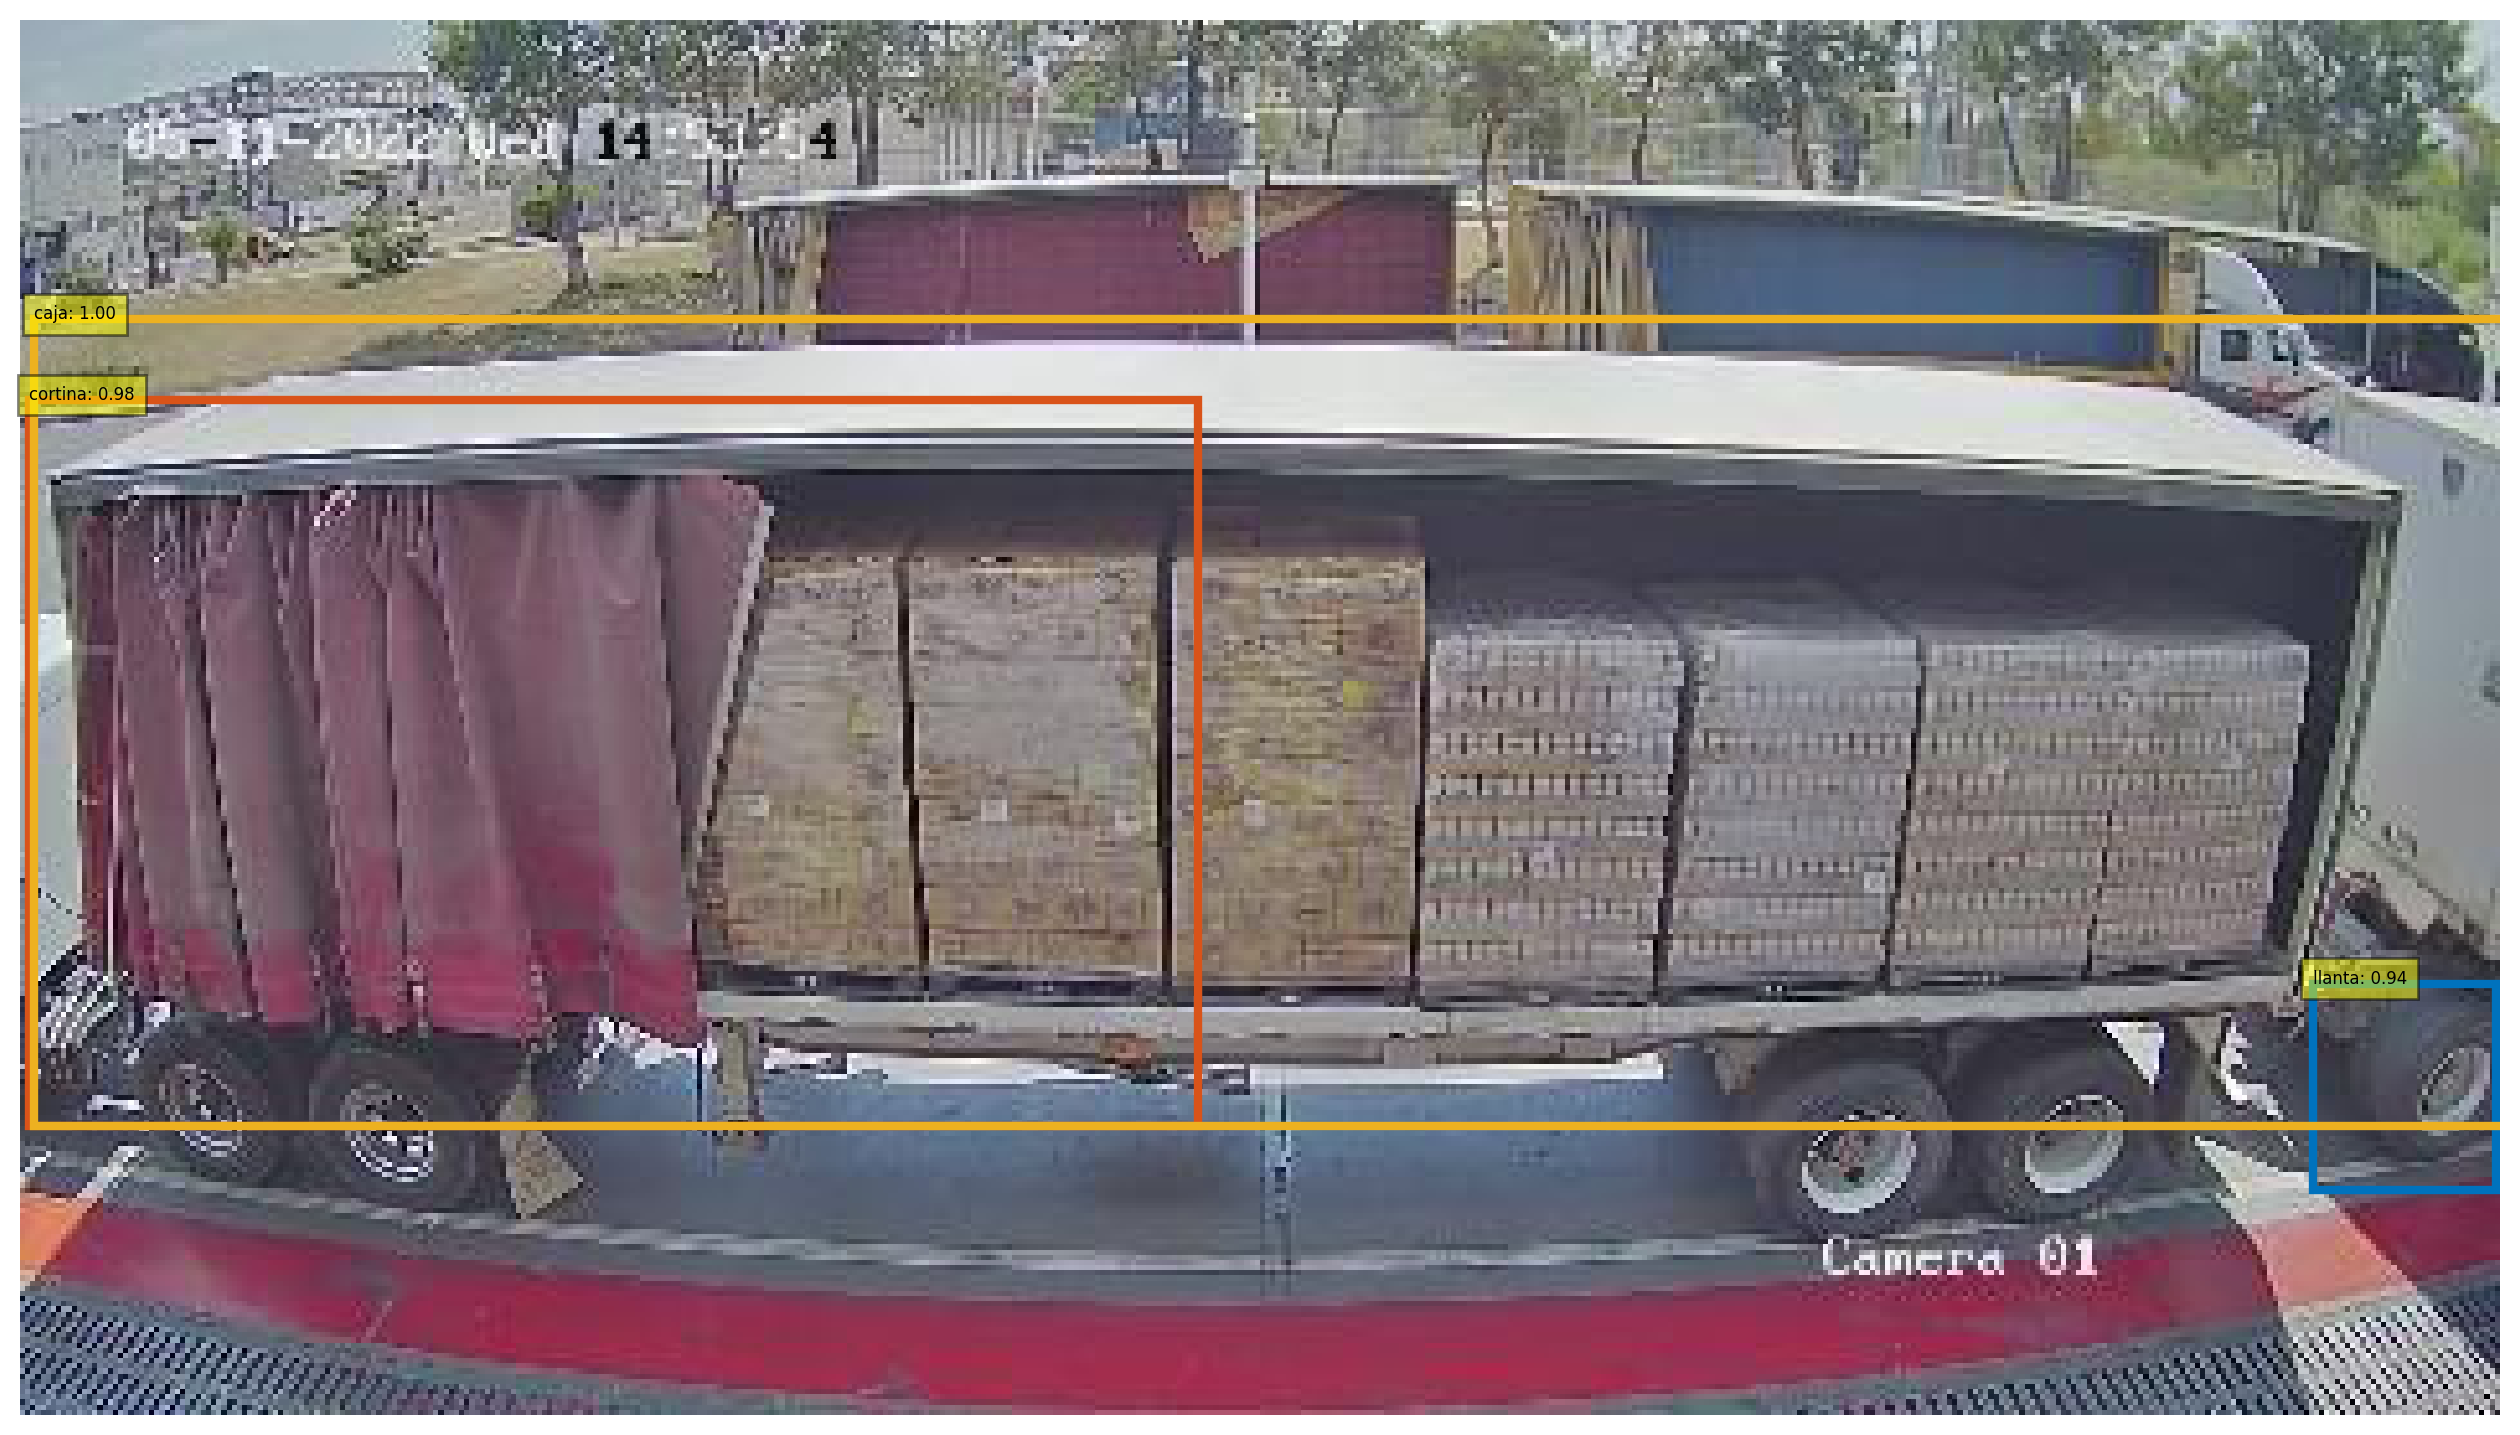

In [40]:
plot_results(im, scores, boxes)

In [ ]:
t=torch.tensor([
    [1, 98, 120, 168, 261, 339],
    [1, 97, 523, 334, 666, 499],
    [1, 94, 0, 0, 160, 169],
    [1, 96, 0, 338, 122, 499],
    [1, 97, 252, 337, 380, 499],
    [1, 98, 402, 1, 548, 174],
    [1, 83, 541, 1, 778, 175],
    [1, 98, 387, 335, 522, 499],
    [1, 97, 127, 338, 285, 499],
    [1, 98, 663, 334, 794, 498],
    [1, 95, 665, 0, 794, 170],
    [1, 96, 118, 1, 277, 170],
    [1, 98, 255, 169, 394, 340],
    [1, 73, 539, 1, 683, 173],
    [1, 97, 265, 1, 415, 174],
    [1, 96, 525, 165, 673, 361],
    [1, 98, 664, 169, 794, 340],
    [1, 97, 398, 170, 526, 340],
    [1, 94, 399, 171, 525, 340],
    [1, 98, 0, 171, 123, 336]
])
print(t.shape)
t

In [ ]:
b=t[:,2:]*1.0
print(b.shape)
b

In [ ]:
p=t[:,1]/100.0
print(p.shape)
p

In [ ]:
keep_indices=nms(boxes=b,scores=p, iou_threshold=0.5)
print(keep_indices.shape)
indices=sorted(keep_indices.tolist())
indices

In [3]:
class D_DETRModel(nn.Module):
    def __init__(self, num_classes=1, model='detr_resnet50'):
        super(D_DETRModel, self).__init__()
        self.num_classes = num_classes
        self.model = torch.hub.load(
            'facebookresearch/detr', 
            model, 
            pretrained=False,
        )
        self.out = nn.Linear(
            in_features=self.model.class_embed.out_features, 
            out_features=num_classes
        )
        
    def forward(self, images):
        d = self.model(images)
        d['pred_logits'] = self.out(d['pred_logits'])
        return d
    
    def parameter_groups(self):
        return { 
            'backbone': [p for n,p in self.model.named_parameters()
                              if ('backbone' in n) and p.requires_grad],
            'transformer': [p for n,p in self.model.named_parameters() 
                                 if (('transformer' in n) or ('input_proj' in n)) and p.requires_grad],
            'embed': [p for n,p in self.model.named_parameters()
                                 if (('class_embed' in n) or ('bbox_embed' in n) or ('query_embed' in n)) 
                           and p.requires_grad],
            'final': self.out.parameters()
        }


In [4]:
DEVICE=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda', index=0)

In [19]:
weights_path='/opt/quantum/vision_transformers/runs/training/detr_resnet50/best_model.pth'
num_classes=6
model = D_DETRModel(num_classes=6, model='detr_resnet50')



Using cache found in /home/fgerard/.cache/torch/hub/facebookresearch_detr_main


In [20]:
ckpt = torch.load(weights_path)
model.load_state_dict(ckpt['model_state_dict'])

<All keys matched successfully>

In [7]:
r_model=model.eval().to(DEVICE)
!ls /mnt/disco2T/opt.old/develop/DATASETS/aduana/dataset-git/output-voc.bk/val | head

labels-val.csv
val.000000.jpg
val.000000.xml
val.000001.jpg
val.000001.xml
val.000002.jpg
val.000002.xml
val.000003.jpg
val.000003.xml
val.000004.jpg
ls: write error: Broken pipe


In [8]:

imgs=[
    "/mnt/disco2T/opt.old/develop/DATASETS/aduana/dataset-git/output-voc.bk/val/val.000000.jpg",
    "/mnt/disco2T/opt.old/develop/DATASETS/aduana/dataset-git/output-voc.bk/val/val.000001.jpg",
    "/mnt/disco2T/opt.old/develop/DATASETS/aduana/dataset-git/output-voc.bk/val/val.000002.jpg"
]
orig_image=cv2.imread(imgs[1])
orig_image.shape

(270, 480, 3)

In [9]:

norm = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)
])
def preProcess(img):
    orig_image=img
    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (300, 300))
    image=norm(image)
    image=image.unsqueeze(0).to(DEVICE)
    return image

In [ ]:
frm=preProcess(orig_image)
frm.shape

In [10]:
def postProcessing(realHeight,realWidth,y_pred):
    result=[]
    pred_boxes=y_pred['pred_boxes']
    pred_logits=y_pred['pred_logits']
    for i in range(pred_boxes.shape[1]):
        logits=pred_logits[0][i]
        soft_logits=torch.softmax(logits, dim=-1)
        max_index = torch.argmax(soft_logits).to("cpu")
        score=soft_logits[max_index] 
        if score > 0.8:
            box = pred_boxes[0][i].to("cpu").numpy()
            cx, cy, w, h = box
            cx = cx * realWidth
            cy = cy * realHeight
            w = w * realWidth
            h = h * realHeight
                
            x1 = int(cx - (w//2))
            y1 = int(cy - (h//2))
            x2 = int(x1 + w)
            y2 = int(y1 + h)
                
            clazz=int(max_index.numpy())
            result.append([clazz,int(100*score),x1,y1,x2,y2])
    return result


In [11]:
def predict(image):
    frm=preProcess(image)
    with torch.no_grad():
        y_pred=r_model(frm)
    height,width,_=image.shape
    pred=postProcessing(height,width,y_pred)
    return pred

In [12]:
y_pred=predict(orig_image)
y_pred

[[5, 96, 0, 155, 8, 183],
 [5, 99, 196, 86, 216, 104],
 [5, 99, 12, 158, 37, 187],
 [5, 99, 135, 28, 257, 83],
 [5, 99, 198, 88, 217, 106],
 [5, 99, 175, 85, 351, 140],
 [5, 99, 186, 88, 209, 108],
 [5, 96, 43, 159, 75, 191],
 [5, 99, 8, 25, 195, 82],
 [5, 99, 33, 25, 210, 84],
 [5, 98, 349, 167, 387, 203],
 [5, 99, 0, 156, 10, 182],
 [5, 98, 420, 68, 478, 185],
 [5, 99, 367, 166, 398, 202],
 [5, 99, 97, 238, 383, 269],
 [5, 99, 136, 76, 162, 96],
 [5, 99, 7, 29, 122, 77],
 [5, 99, 385, 54, 413, 80],
 [5, 99, 349, 168, 388, 205],
 [5, 99, 118, 67, 289, 119],
 [5, 98, 342, 135, 369, 157],
 [5, 99, 351, 168, 389, 205],
 [5, 99, 429, 70, 478, 171],
 [5, 99, 456, 52, 478, 75],
 [5, 99, 303, 169, 344, 207],
 [5, 99, 305, 169, 347, 207],
 [5, 99, 441, 72, 478, 103],
 [5, 99, 151, 76, 241, 114],
 [5, 99, 175, 57, 220, 88],
 [5, 99, 8, 56, 23, 78],
 [5, 92, 0, 155, 10, 183],
 [5, 99, 192, 90, 212, 108],
 [5, 99, 1, 156, 18, 184],
 [5, 99, 444, 64, 476, 89],
 [5, 99, 442, 73, 478, 131],
 [5, 99

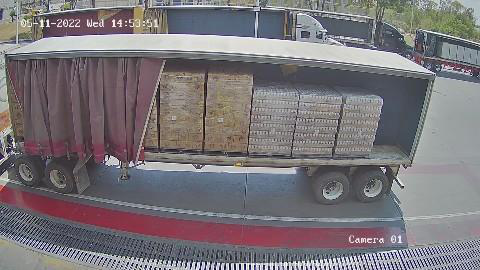

In [13]:
from PIL import Image

# Ruta de la imagen
image_path = imgs[1]

# Abrir la imagen
img = Image.open(image_path)

# Mostrar la imagen
img.show()